# SHAP Modeling
## "Offspring genetic diversity regulates rearing experiences that predict differential susceptibility to Chd8 haploinsufficiency"

In [1]:
# Required Import Statements
import pandas as pd
import numpy as np
import shap
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.image as mpimg
import seaborn as sns

c:\Users\ruler\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Cleaning

In [2]:
# Import Data
chd8_het_effect = pd.read_excel('chd8_het_effect.xlsx')

In [3]:
# Rename Columns for chd8 het effects dataframe
chd8_het_effect = chd8_het_effect.rename(columns={'Weaning body weight': 'Weaning Body Weight', 'Adolescent body weight':'Adolescent Body Weight',
       'Adult body weight':'Adult Body Weight', 'Terminal body weight':'Terminal Body Weight', 'Brain weight':'Brain Weight',
       'DOF distance':'DOF Distance', 'DSI aggression':'DSI Aggression', 'DSI sniffing':'DSI Sniffing',
       'BOF % center distance': 'BOF % Center Distance', 'Fear acquisition':'Fear Acquisition', 'Fear expression':'Fear Expression',
       'Fear extinction': 'Fear Extinction'})

chd8_het_effect = chd8_het_effect.rename(columns={'Nest quality':'Nest Quality', 'dam_active_nurse': 'Dam Active Nurse', 'dam run': 'Dam Run',
       'dam_eat':'Dam Eat', 'dam_lick': 'Dam Lick', 'dam_nest_build': 'Dam Nest Build', 'dam_outnest': 'Dam Out of Nest',
       'dam_pass nurse': 'Dam Passive Nurse', 'dam_rest':'Dam Rest', 'total nurse': 'Total Nurse',
       'Pup_climb': 'Pup Climb', 'Pup_crawl/run': 'Pup Crawl/Run', 'Pup dig': 'Pup Dig', 'Pup autogroom':'Pup Autogroom',
       'pup_eat solid':'Pup Eat Solid', 'pup_eyes open':'Pup Eyes Open', 'pup jump': 'Pup Jump', 'pup L/G':'Pup L/G',
       'pup nest build':'Pup Nest Build', 'Litter size':'Litter Size'})

In [4]:
# List of target variables
target_variables = ['Weaning Body Weight', 'Adolescent Body Weight',
       'Adult Body Weight', 'Terminal Body Weight', 'Brain Weight',
       'DOF Distance', 'DSI Aggression', 'DSI Sniffing',
       'BOF % Center Distance', 'Fear Acquisition', 'Fear Expression',
       'Fear Extinction']

## Compute SHAP Models

In [5]:
def get_shap_tree(x, y):
    # Step 1: Fit a decision tree
    tree = DecisionTreeRegressor(random_state=42, max_depth=5)
    tree.fit(x, y)

    # Step 2: Compute SHAP values
    explainer = shap.TreeExplainer(tree)
    shap_values = explainer.shap_values(x)

    # Step 3: Get mean absolute SHAP values for feature importance
    shap_importance = np.abs(shap_values).mean(axis=0)

    shap_df = pd.DataFrame({
        'feature': x.columns,
        'importance': shap_importance
    }).sort_values(by='importance', ascending=False)

    # Step 4: Filter features with SHAP < 0.01 and keep top 5 (plus 'Sex')
    filtered_features = shap_df[shap_df['importance'] > 0.01].head(6)['feature'].tolist()
    if 'Sex' not in filtered_features:
        filtered_features.append('Sex')
    x_filtered = x[filtered_features]

    # Step 5: Refit the decision tree with filtered features
    tree_filtered = DecisionTreeRegressor(random_state=42, max_depth=5)
    tree_filtered.fit(x_filtered, y)

    # Step 6: Compute SHAP values again for the filtered model
    explainer_filtered = shap.TreeExplainer(tree_filtered)
    shap_values_filtered = explainer_filtered.shap_values(x_filtered)
    
    return shap_values_filtered, x_filtered, tree_filtered

## SHAP Plotting

In [6]:
def graph_with_r2_and_clustering_sex_shaded(shap_vals, x, y, title, grad_boost):
    """
    Generate SHAP bar plot with sex cohorts and display R^2 value.
    
    Parameters:
    shap_vals: SHAP values
    x: Features dataframe
    y: Target variable series
    title: Title for the plot
    grad_boost: Trained model
    """
    ############## SHAP CALCULATIONS ##############

    # Calculate R2
    r2 = r2_score(y, grad_boost.predict(x))
    
    # Define sex cohorts for shading
    sex = ['Male' if x.iloc[i]['Sex'] == 0 else 'Female' for i in range(x.shape[0])]
    
    # Exclude 'Sex' column from features
    x_no_sex = x.drop(columns=['Sex'])

    # Filter SHAP values to exclude 'Sex'
    feature_names = x.columns.tolist()
    valid_features = [name for name in feature_names if name != 'Sex']
    feature_indices = [x.columns.get_loc(name) for name in valid_features]
    shap_vals_no_sex = shap_vals[:, feature_indices]

    shap_values_explanation = shap.Explanation(values=shap_vals_no_sex, 
                                               data=x_no_sex, 
                                               feature_names=x_no_sex.columns)

    clustering = shap.utils.hclust(x_no_sex, y)

    ############## PLOTTING ##############
    fig = plt.figure(figsize=[12,8])  # Explicit figure size
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.2f}"))    

    # Create the SHAP bar plot with sex cohorts
    shap.plots.bar(
        shap_values_explanation.cohorts(sex).abs.mean(0),
        clustering=clustering,
        clustering_cutoff=1, 
        max_display=10,
        show=False,
        ax=ax,

    )

    ############## MANAGE LABEL FORMATTING ##############

    for text in ax.get_xticklabels() + ax.get_yticklabels():
        text.set_fontsize(24)

    for text in ax.get_xticklabels():
        text.set_text

    xlabel = ax.get_xlabel()
    if xlabel:
        ax.set_xlabel("Mean |SHAP|", fontsize=24)

    for child in ax.get_children():
        if hasattr(child, 'set_fontsize'):
            child.set_fontsize(24)
    
    legend = ax.get_legend()
    if legend is not None:
        if legend.get_title() is not None:
            legend.get_title().set_fontsize(20)
        for text in legend.get_texts():
            text.set_fontsize(20)

    ax.set_title(f'{title}\nR² = {r2:,.2f}', y=1, fontsize=24)

    ############## FINAL PLOTTING ##############

    # Save the plot with lower dpi to reduce file size
    plt.savefig(f'Images/{title}.png', bbox_inches='tight')

    # Display the plot
    plt.show()

## Display SHAP Plots

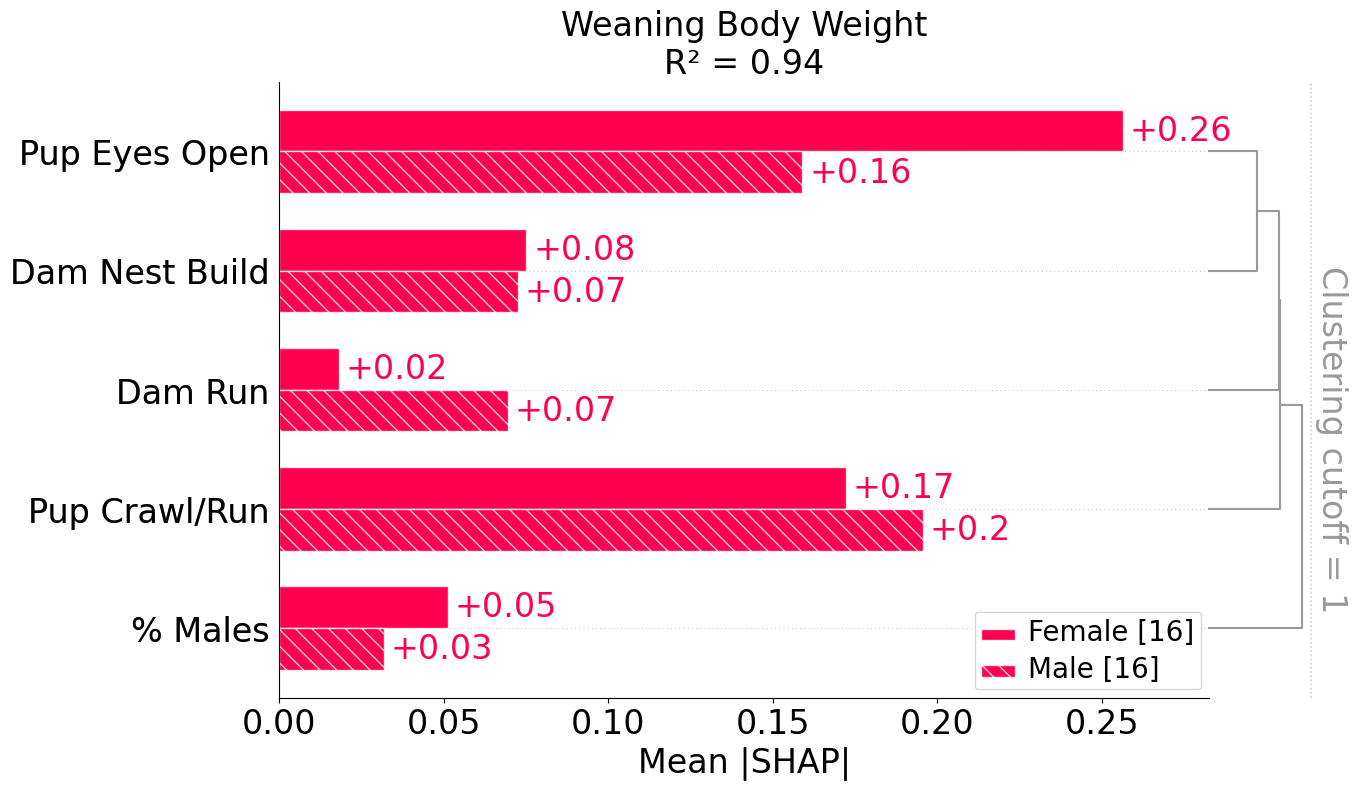

c:\Users\ruler\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 3 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(


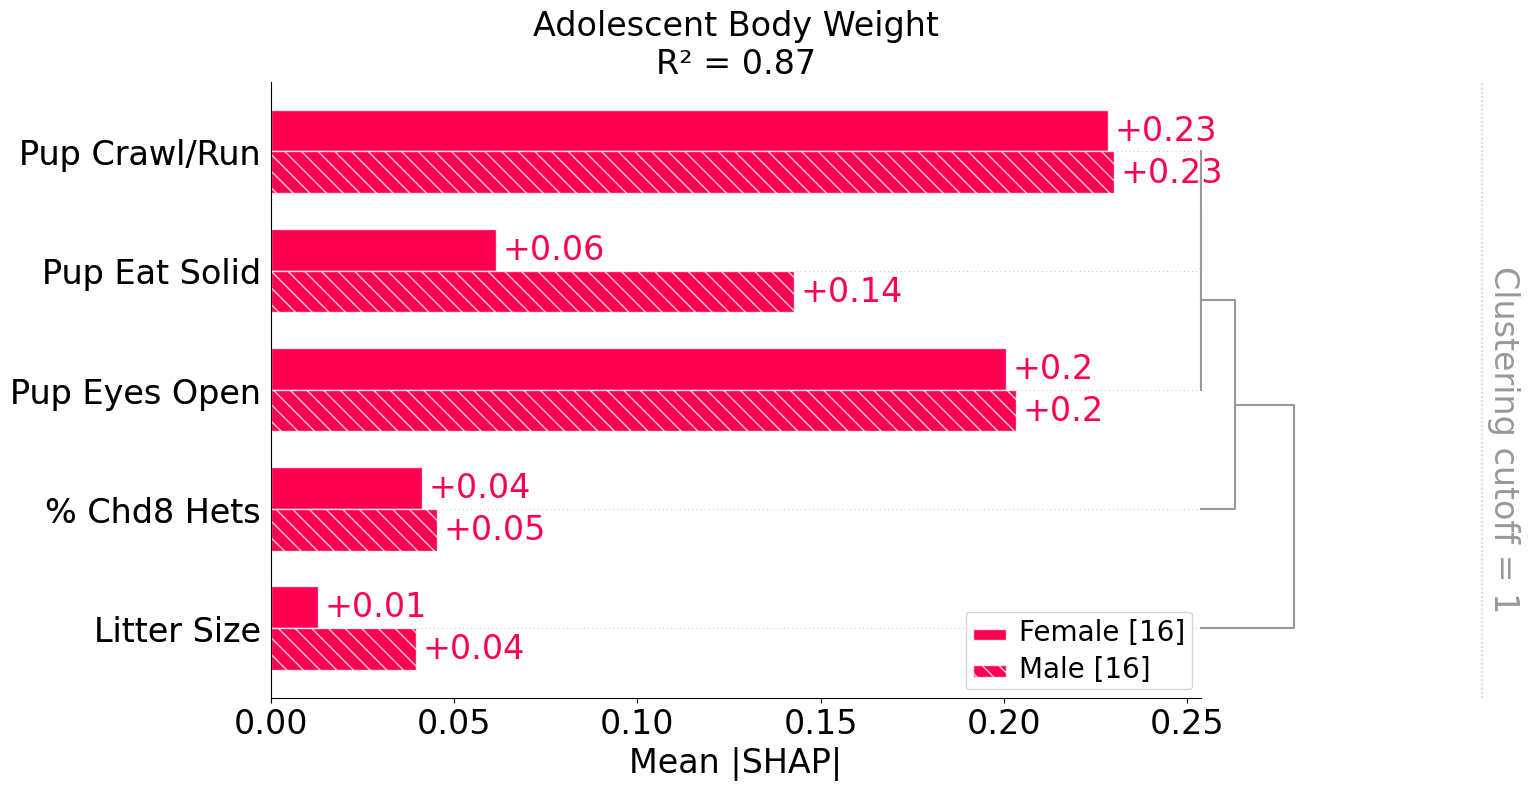

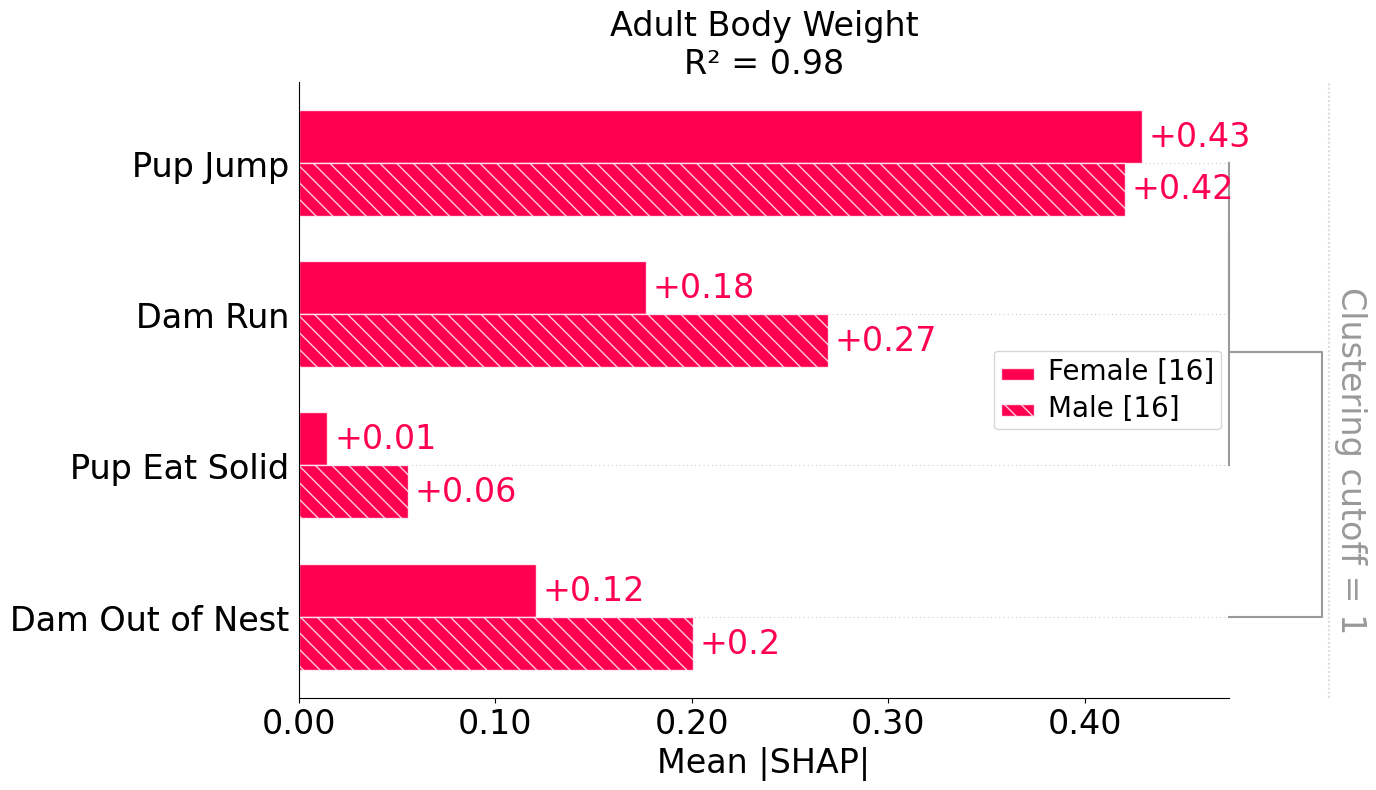

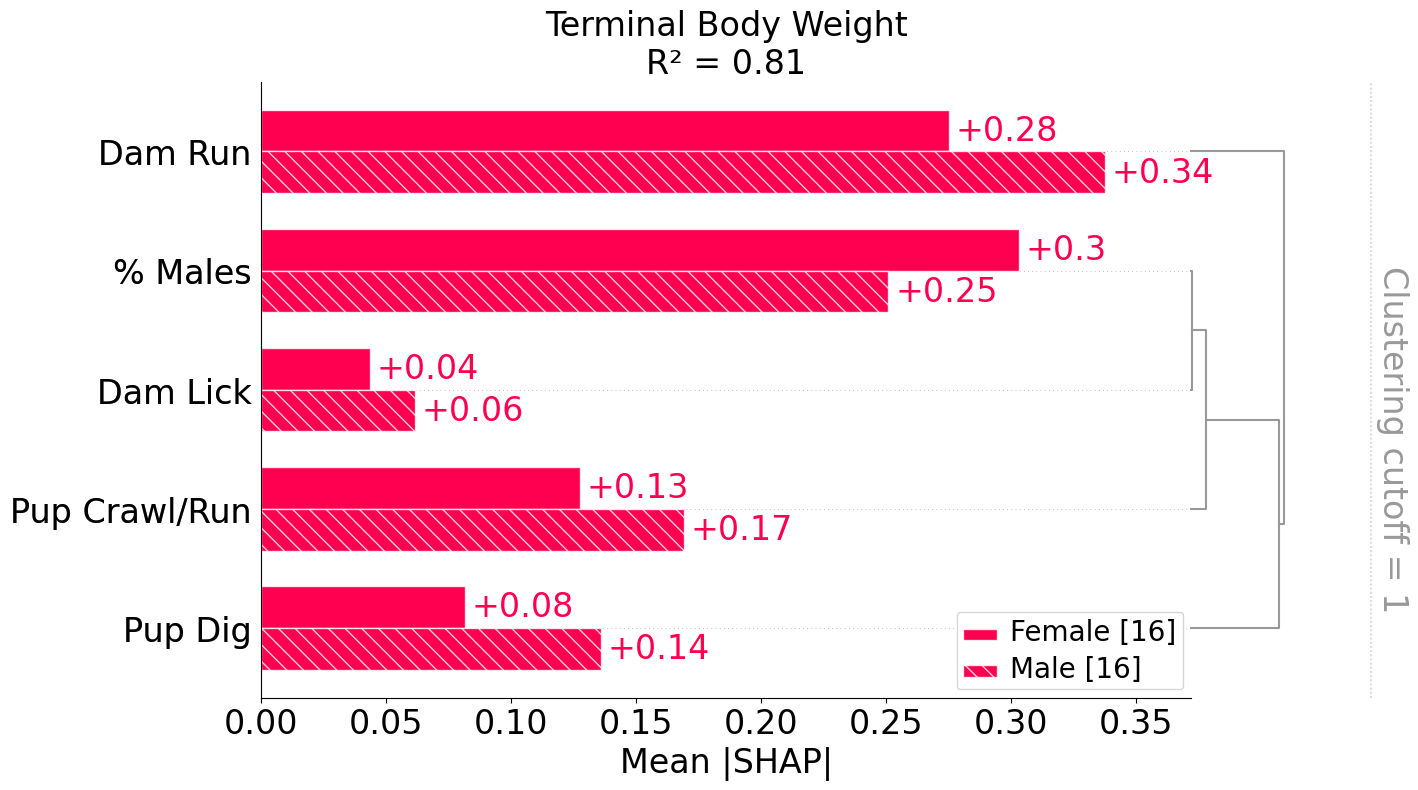

c:\Users\ruler\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(


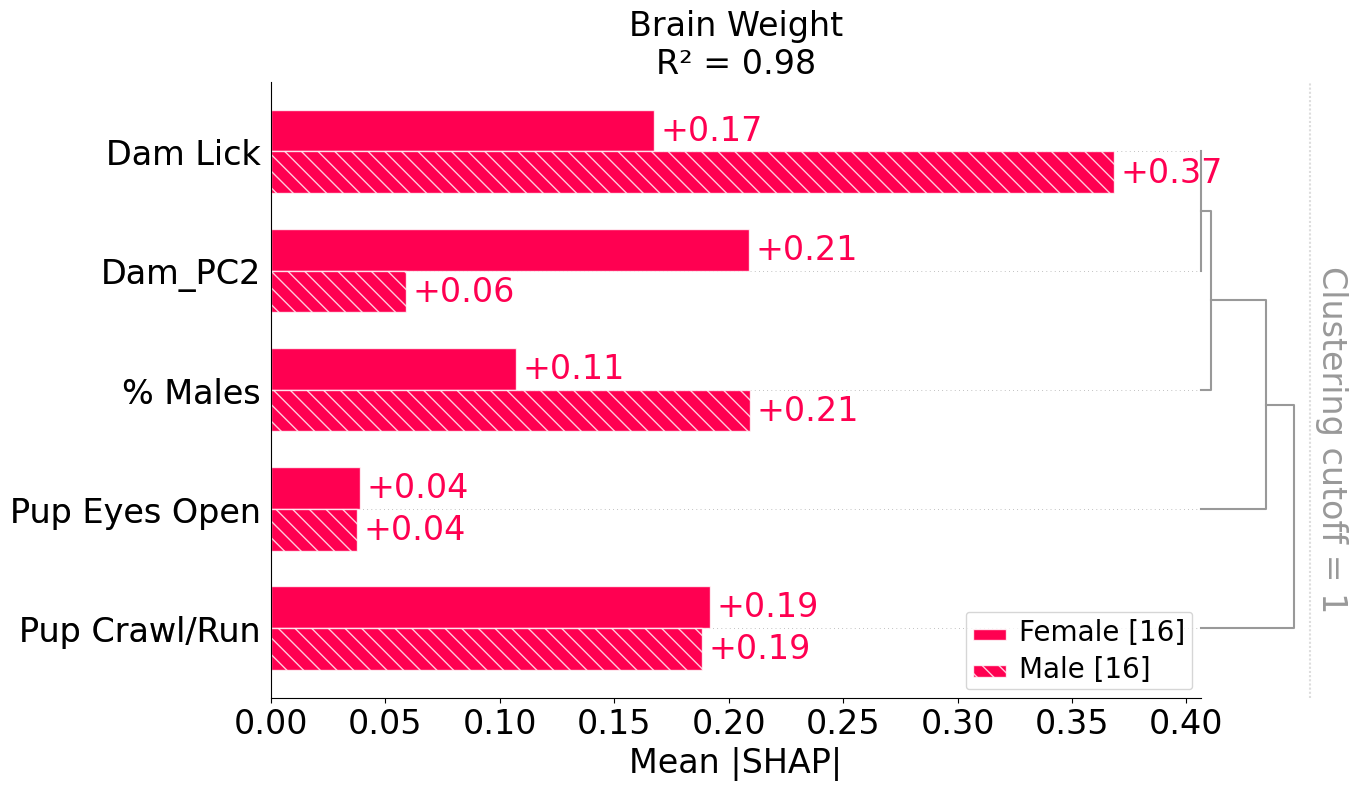

c:\Users\ruler\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(


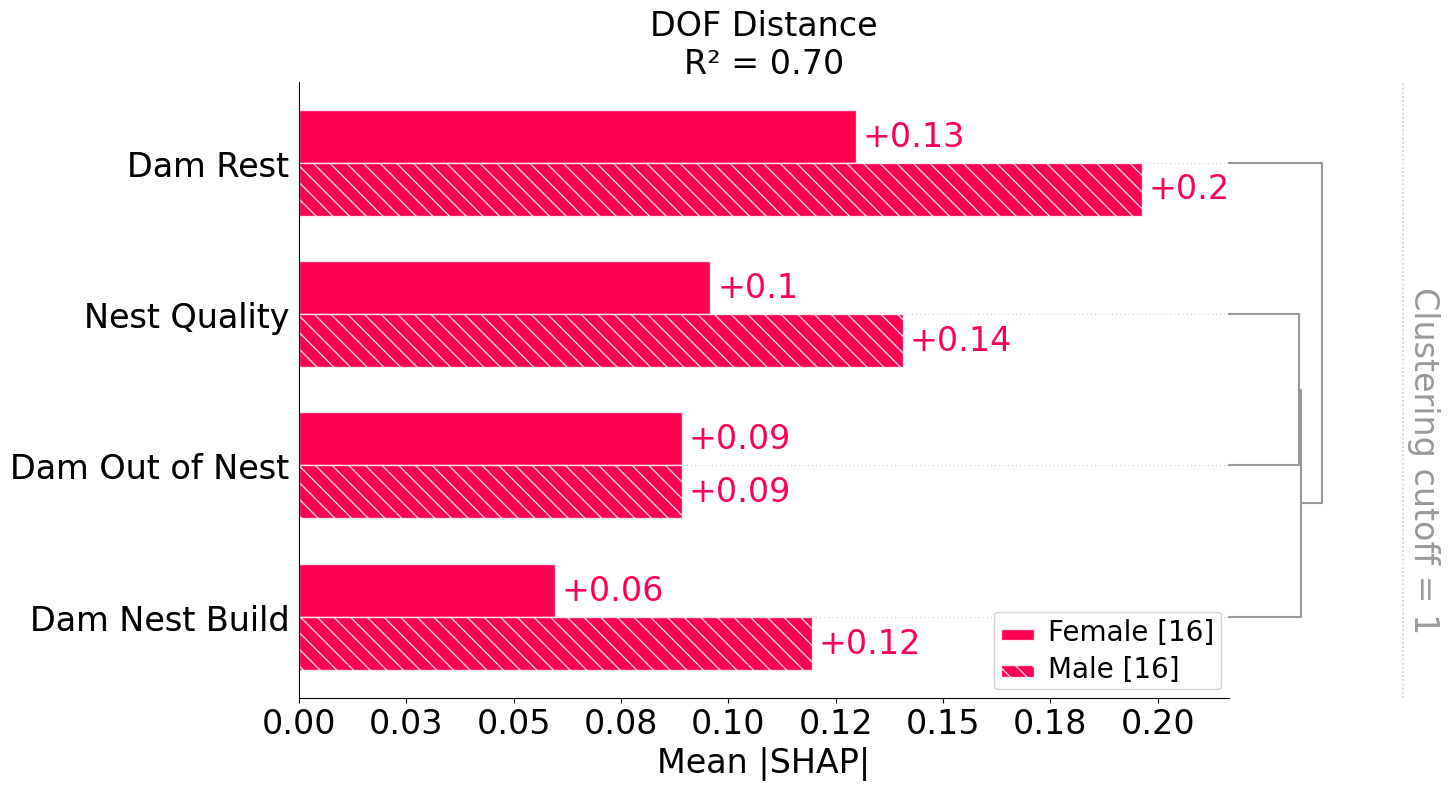

c:\Users\ruler\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(


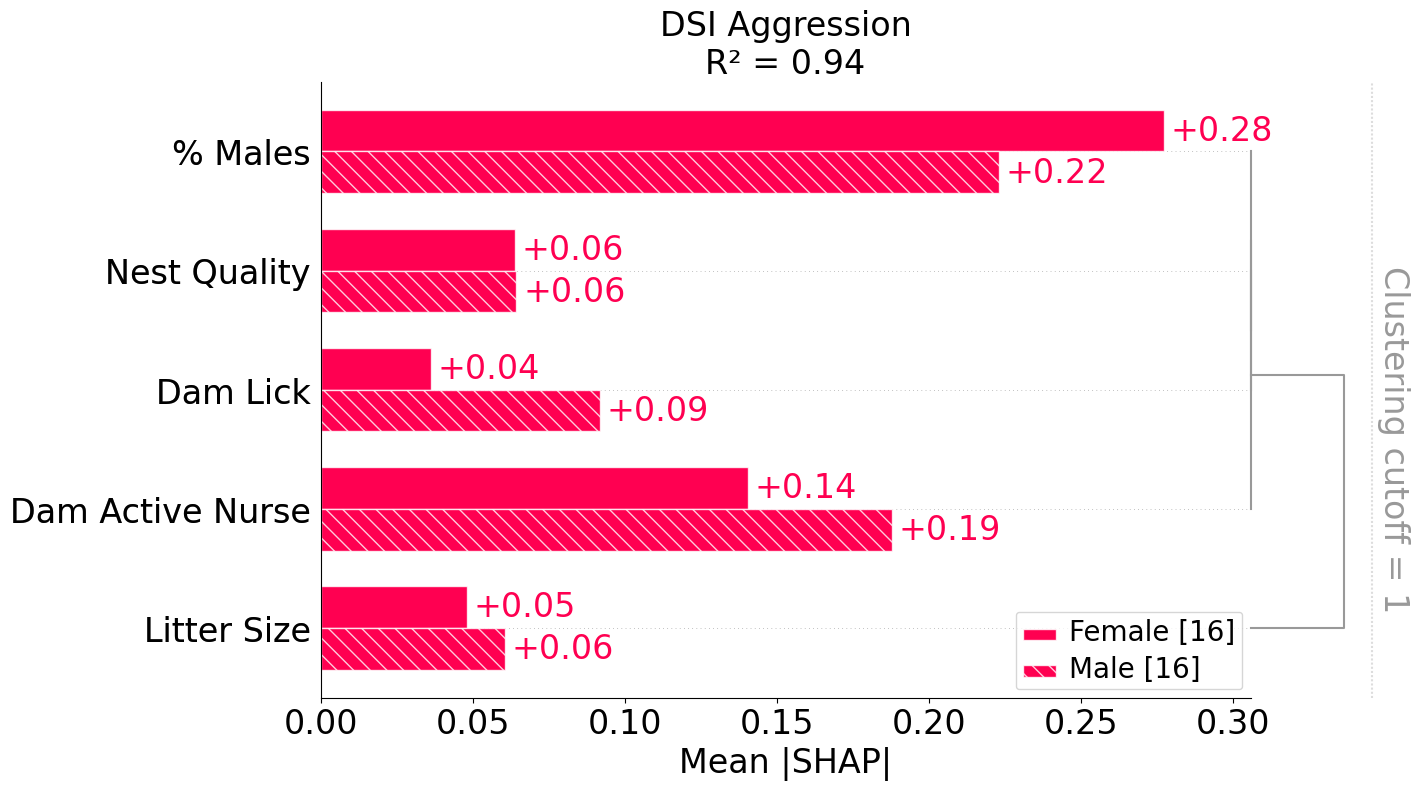

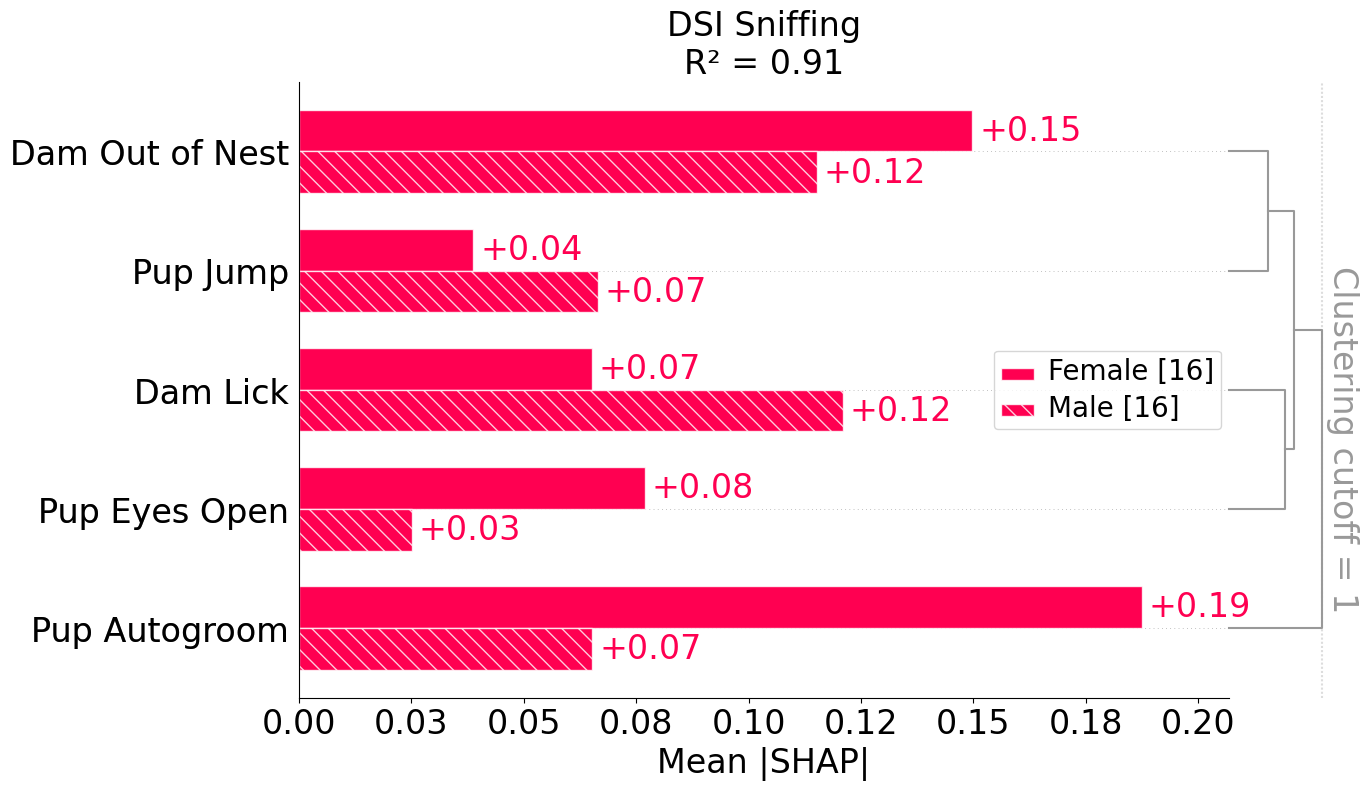

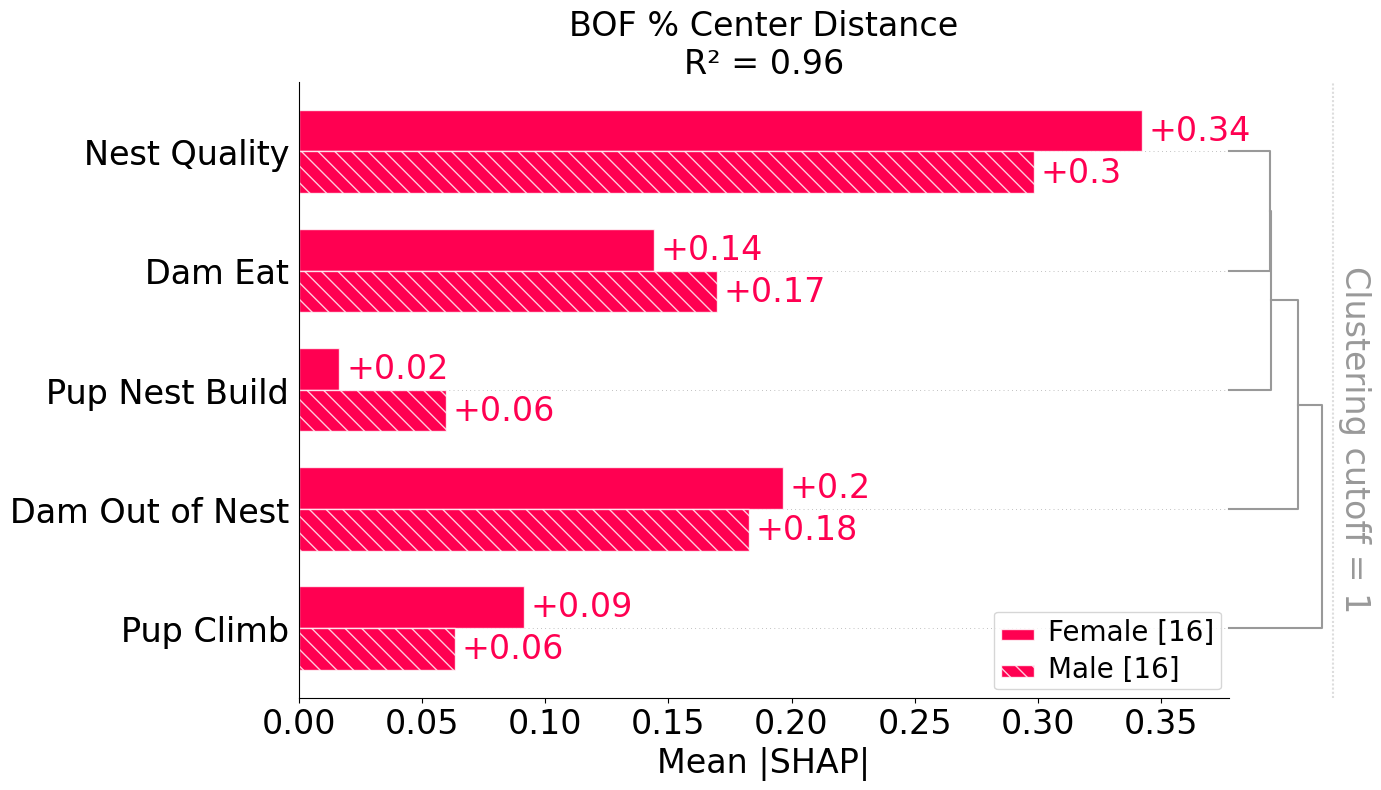

c:\Users\ruler\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(


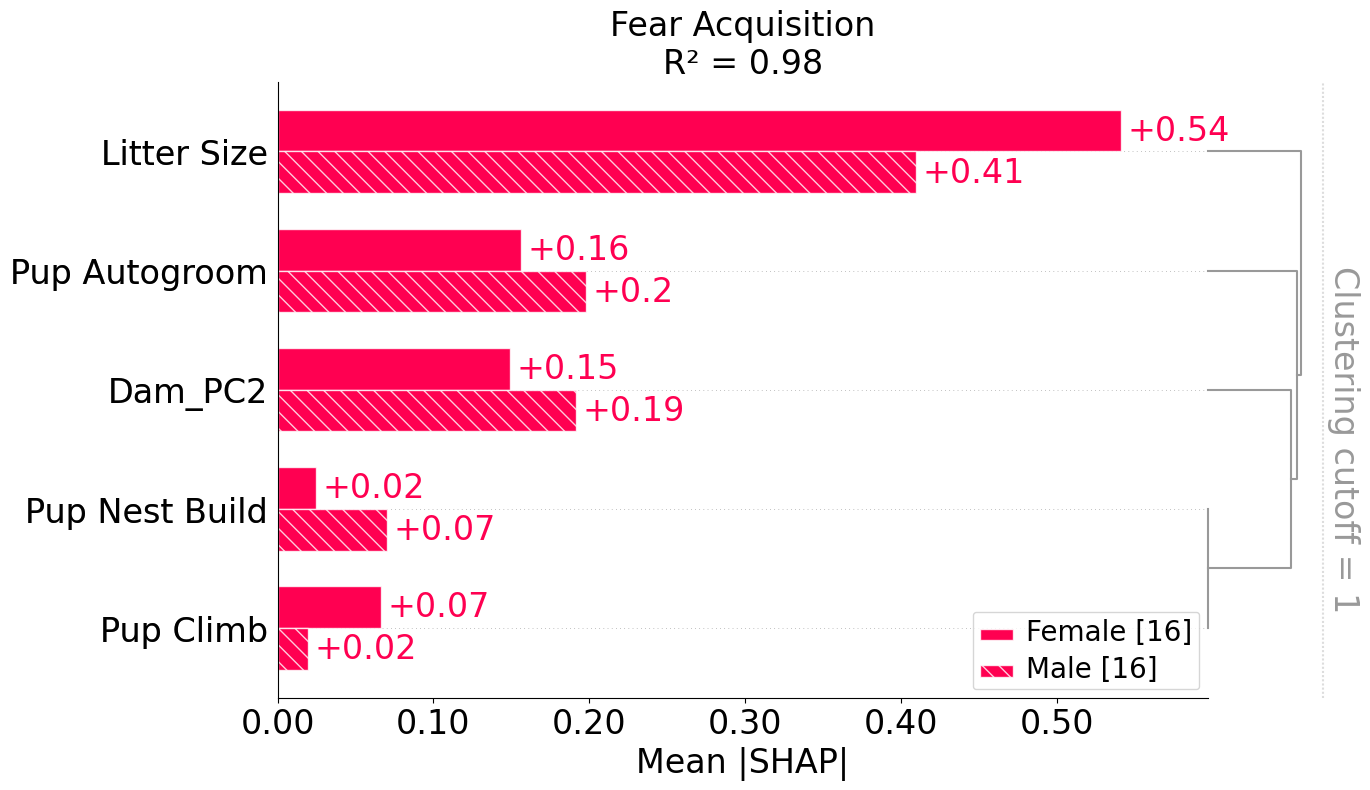

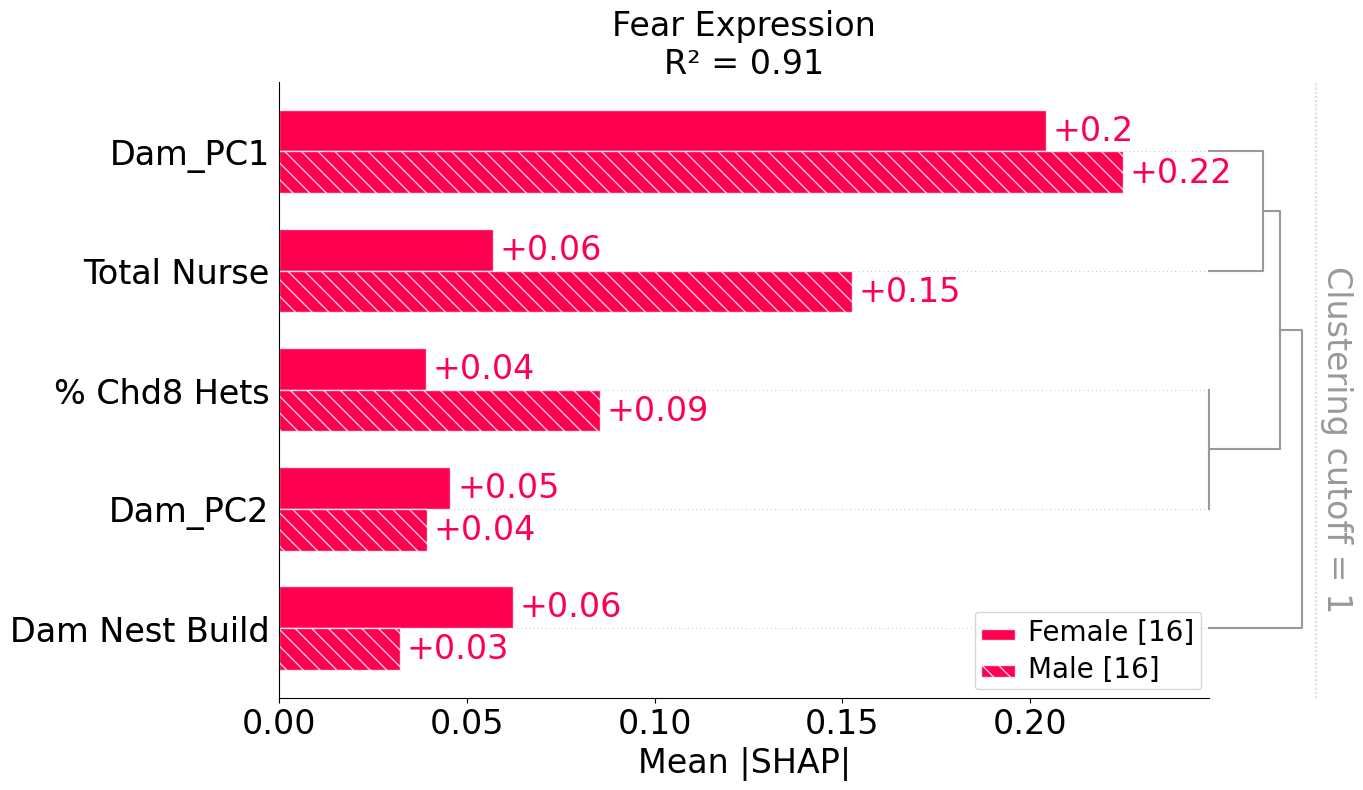

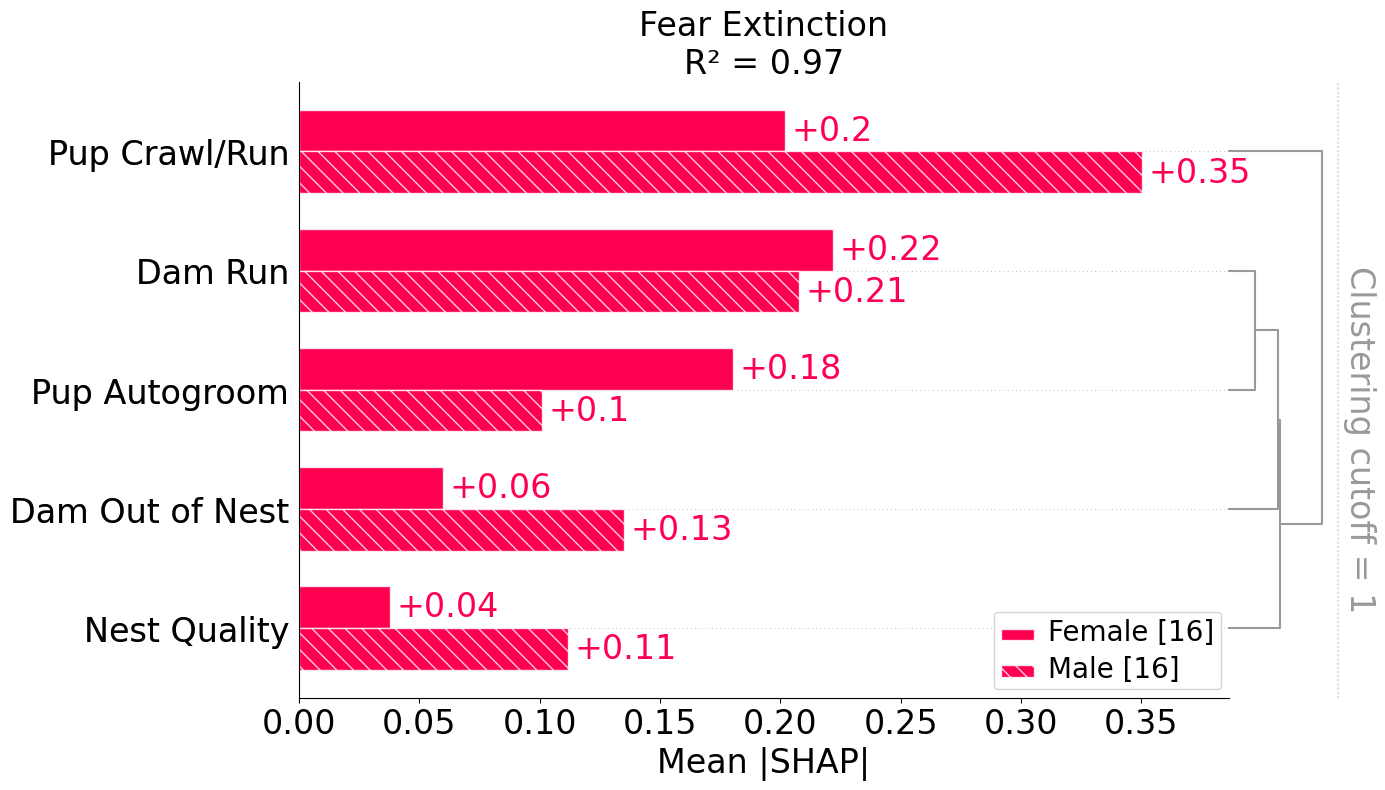

In [7]:
for target in target_variables:
    # Define target variable
    y = chd8_het_effect[target]
    x = chd8_het_effect[['Nest Quality', 'Dam Active Nurse', 'Dam Run',
       'Dam Eat', 'Dam Lick', 'Dam Nest Build', 'Dam Out of Nest',
       'Dam Passive Nurse', 'Dam Rest', 'Total Nurse', 'Dam_PC1', 'Dam_PC2',
       'Pup Climb', 'Pup Crawl/Run', 'Pup Dig', 'Pup Autogroom',
       'Pup Eat Solid', 'Pup Eyes Open', 'Pup Jump', 'Pup L/G',
       'Pup Nest Build', 'Litter Size', '% Chd8 Hets', '% Males', 'Sex']]

    # Delete parts of SHAP tree with values of ~0
    x_filtered = x
    zeros = True
    while zeros:
        shap_values_filtered, x_filtered, tree_filtered = get_shap_tree(x_filtered, y)
        if np.all(np.abs(shap_values_filtered).mean(axis=0) >= 0.01):
            zeros = False

    # Call the graphing function
    graph_with_r2_and_clustering_sex_shaded(shap_values_filtered, x_filtered, y, title=target, grad_boost=tree_filtered)
    plt.show()


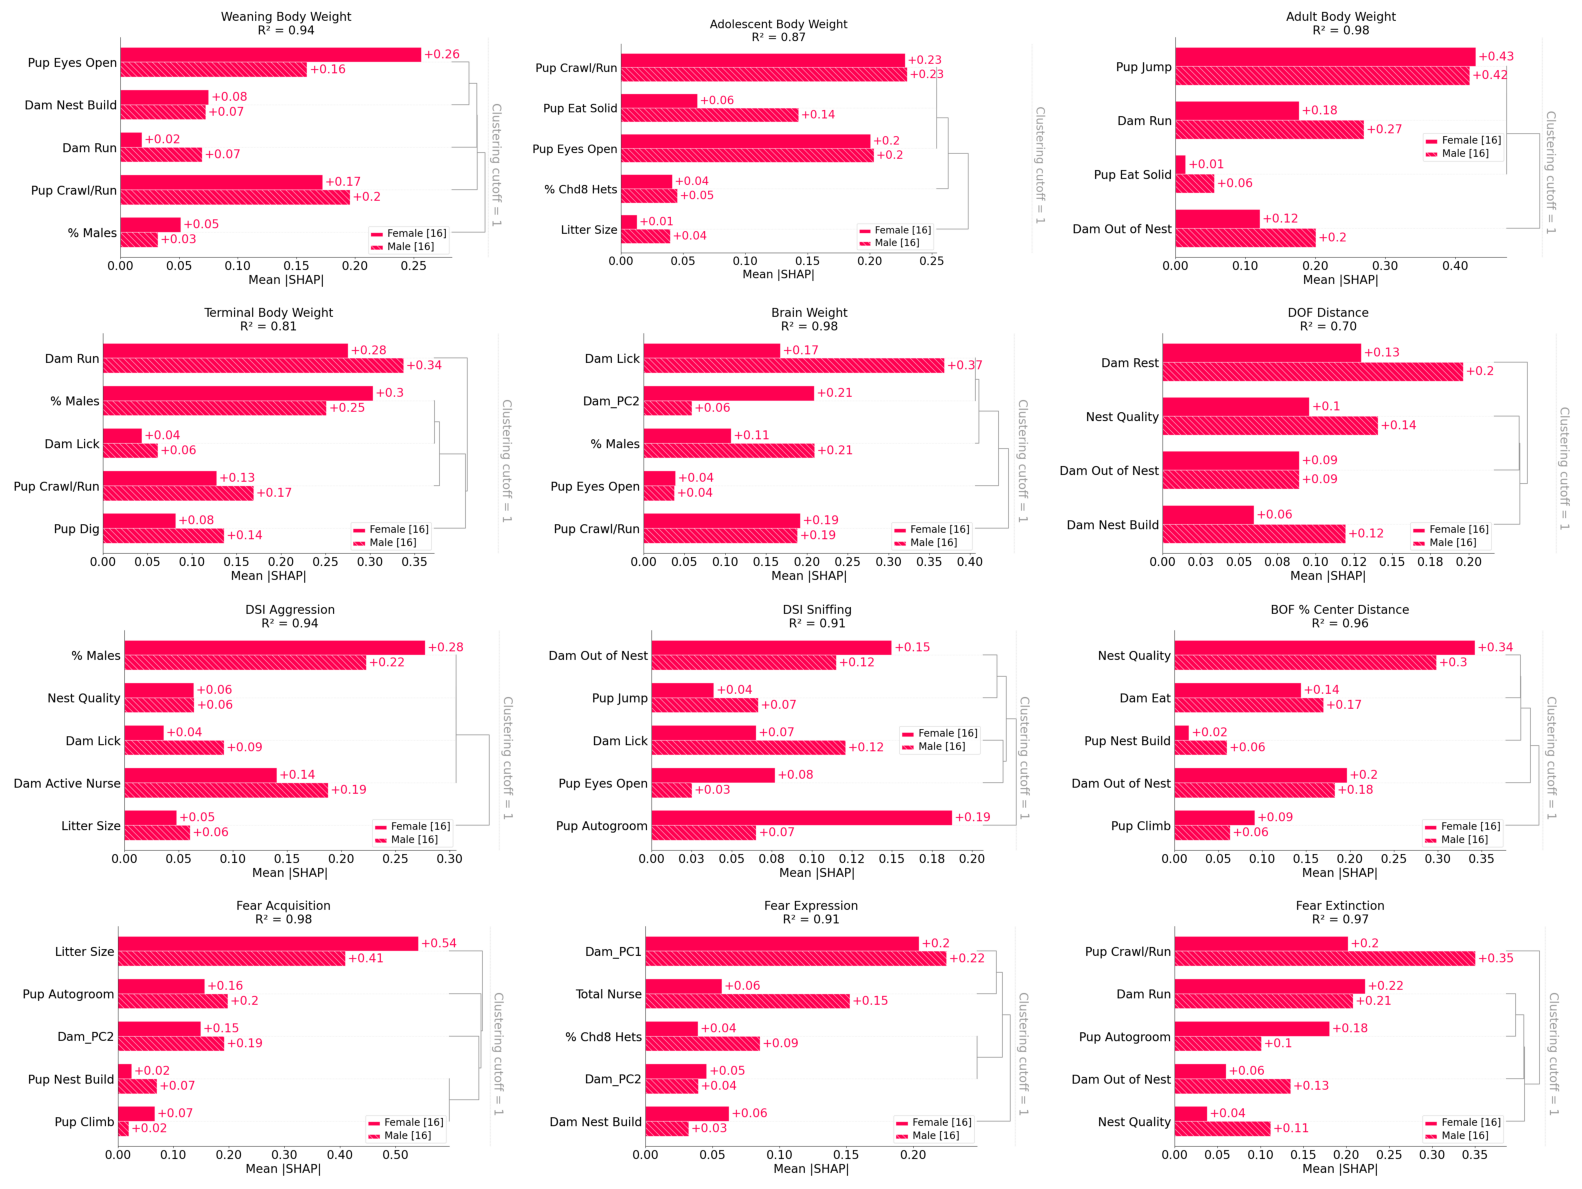

In [8]:
################## COMBINE PLOTS ##################
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
images = [['Weaning Body Weight', 'Adolescent Body Weight',
           'Adult Body Weight'], ['Terminal Body Weight', 'Brain Weight',
                                 'DOF Distance'], ['DSI Aggression', 'DSI Sniffing',
                                                    'BOF % Center Distance'], ['Fear Acquisition', 'Fear Expression',
                                                                                'Fear Extinction']]

# Loop over the rows and columns to display images
for row in [0, 1, 2, 3]:

    for column in [0, 1, 2]:
        ax = axes[row, column]
        ax.axis('off')
        image_name = images[row][column]
        img = mpimg.imread(f'Images/{image_name}.png')
        ax.imshow(img)

# Adjust layout to make room for the figure title
plt.tight_layout()
# Save the figure with higher resolution
plt.savefig('Images/decision_tree_shap.png', dpi=300, bbox_inches='tight')
plt.rc('font', size=14)

# Display the plot
plt.show()


## Distribution Plots

In [9]:
def get_final_cohort_df(cohorts, valid_features):
    # Create initial lists/dicts
    data = {feat: [] for feat in valid_features}
    data['Sex'] = []
    sexes = [k for k in cohorts.cohorts.keys() if k in ("Male", "Female")]

    # Add features and values to lists/dicts
    for sex in sexes:
        rows = cohorts.cohorts[sex].values
        for pup in rows:
            length = len(pup)
            for idx, feat in enumerate(valid_features):
                if idx < length:
                    data[feat].append(pup[idx])
            data['Sex'].append(sex)
            
    return pd.DataFrame(data)

In [10]:
def get_cohorts(x_filtered, shap_values_filtered):
    # Define sex cohorts for shading
    sex = ['Male' if x_filtered.iloc[i]['Sex'] == 0 else 'Female' for i in range(x_filtered.shape[0])]

    # Exclude 'Sex' column from features
    x_no_sex = x_filtered.drop(columns=['Sex'])

    # Filter SHAP values to exclude 'Sex'
    feature_names = x_filtered.columns.tolist()
    valid_features = [name for name in feature_names if name != 'Sex']
    feature_indices = [x_filtered.columns.get_loc(name) for name in valid_features]
    shap_vals_no_sex = shap_values_filtered[:, feature_indices]

    shap_values_explanation = shap.Explanation(values=shap_vals_no_sex, 
                                                data=x_no_sex, 
                                                feature_names=x_no_sex.columns)

    return shap_values_explanation.cohorts(sex).abs

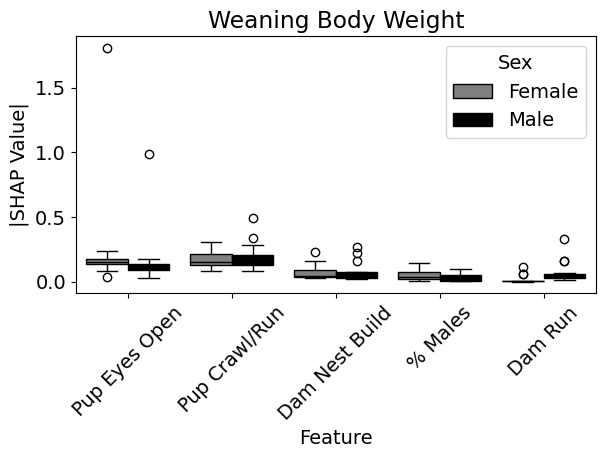

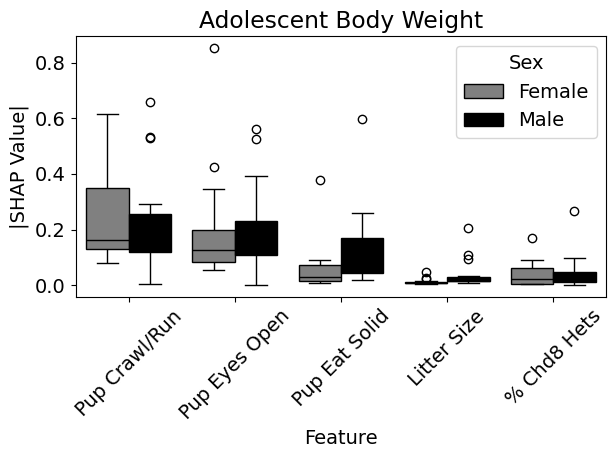

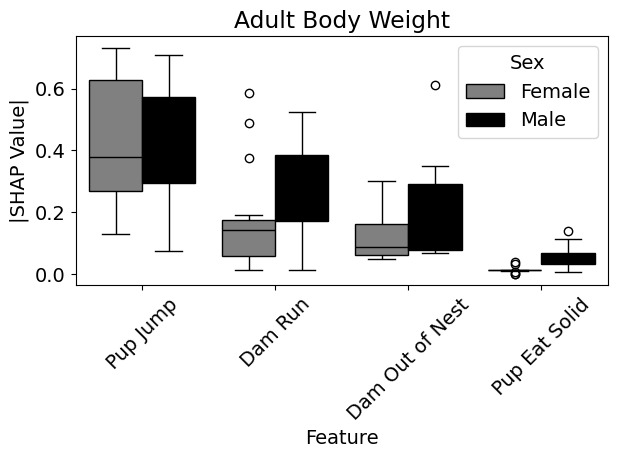

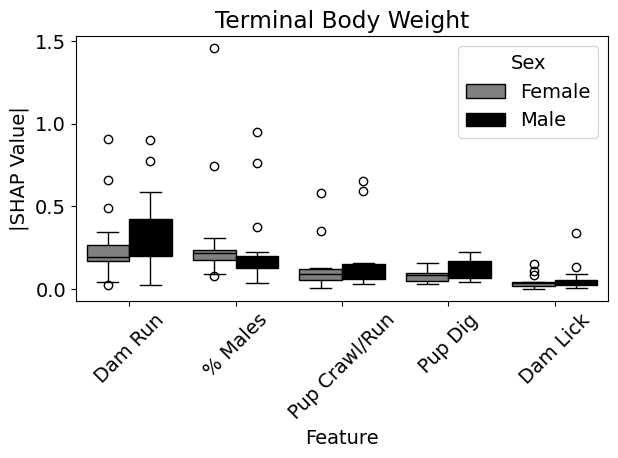

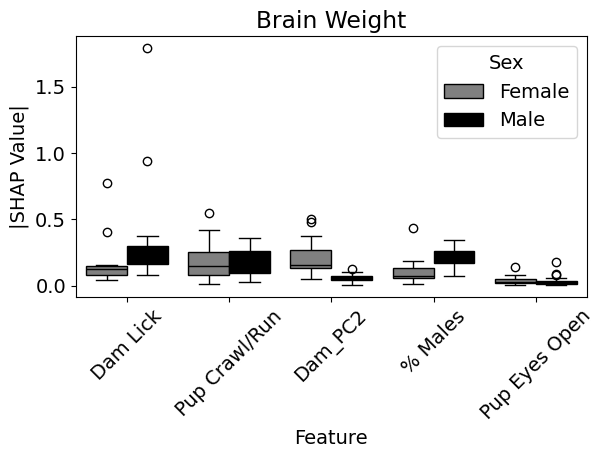

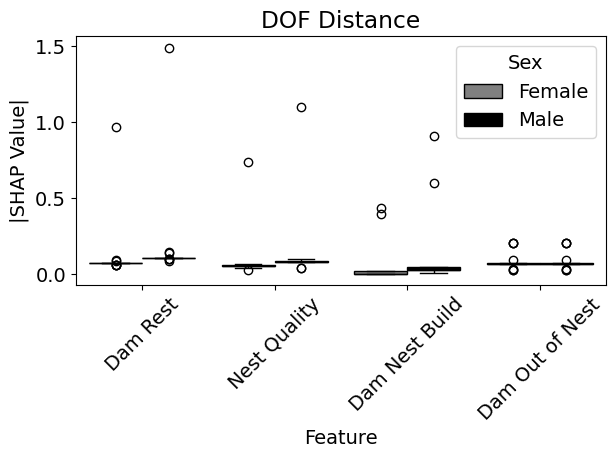

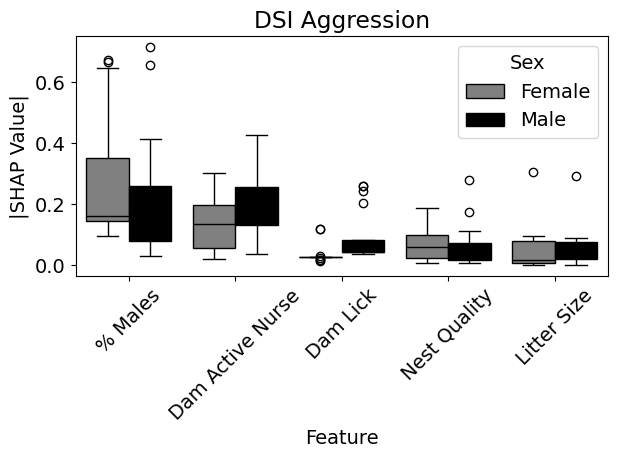

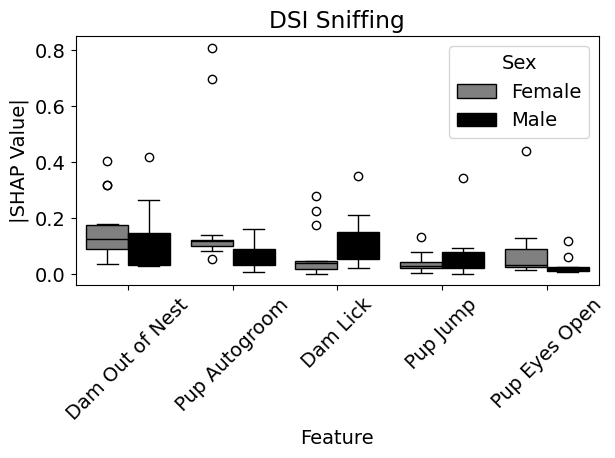

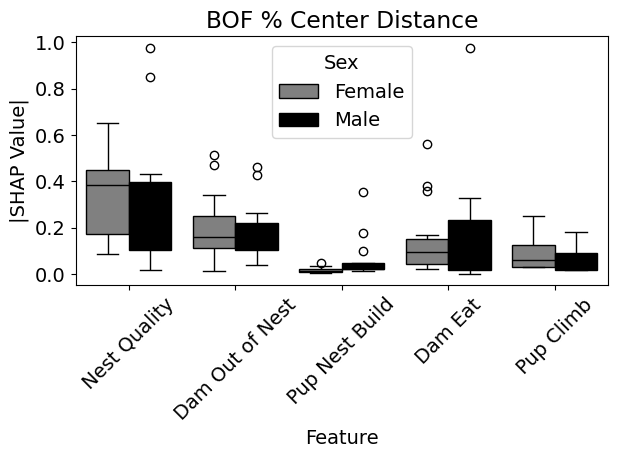

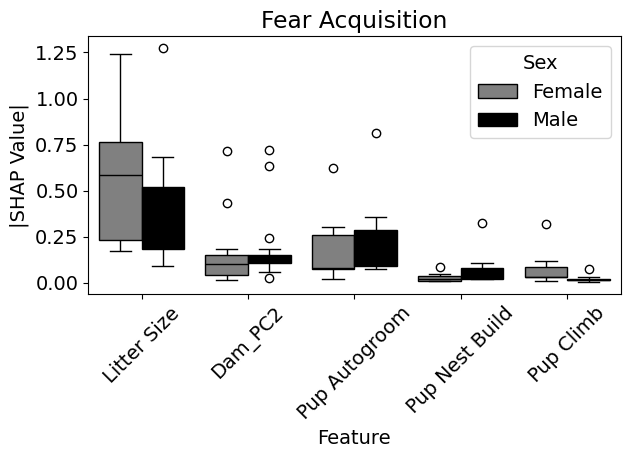

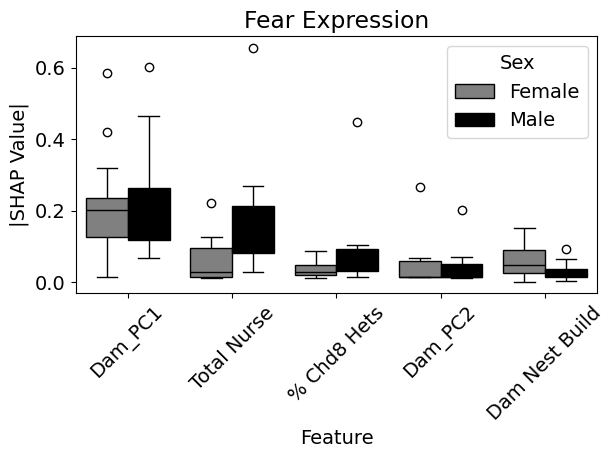

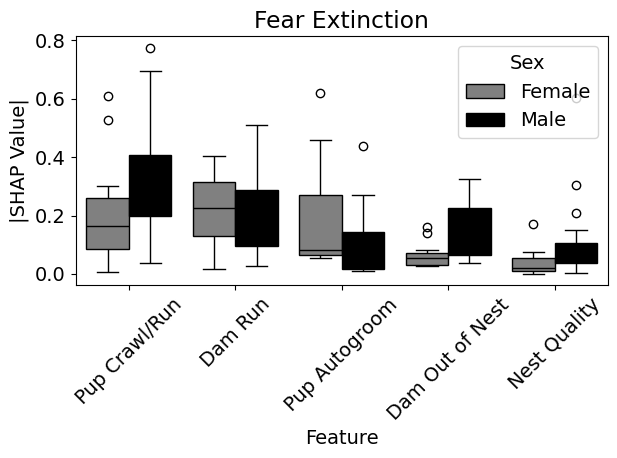

In [11]:
for target in target_variables:
    y = chd8_het_effect[target]
    x = chd8_het_effect[['Nest Quality', 'Dam Active Nurse', 'Dam Run',
        'Dam Eat', 'Dam Lick', 'Dam Nest Build', 'Dam Out of Nest',
        'Dam Passive Nurse', 'Dam Rest', 'Total Nurse', 'Dam_PC1', 'Dam_PC2',
        'Pup Climb', 'Pup Crawl/Run', 'Pup Dig', 'Pup Autogroom',
        'Pup Eat Solid', 'Pup Eyes Open', 'Pup Jump', 'Pup L/G',
        'Pup Nest Build', 'Litter Size', '% Chd8 Hets', '% Males', 'Sex']]

    # Delete parts of SHAP tree with values of ~0
    x_filtered = x
    zeros = True
    while zeros:
        shap_values_filtered, x_filtered, tree_filtered = get_shap_tree(x_filtered, y)
        if np.all(np.abs(shap_values_filtered).mean(axis=0) >= 0.01):
            zeros = False

    # Get cohorts
    cohorts =  get_cohorts(x_filtered, shap_values_filtered)
    feature_names = x_filtered.columns.tolist()
    valid_features = [name for name in feature_names if name != 'Sex']
    cohort_df = get_final_cohort_df(cohorts, valid_features)

    # Make dataframe long-format
    long_df = cohort_df.melt(id_vars='Sex', 
                         value_vars=valid_features,
                         var_name='Feature',
                         value_name='Value')

    # Plot and save graphs
    sns.boxplot(data=long_df, x='Feature', y='Value', hue='Sex', palette=sns.color_palette(['gray', 'black']))
    plt.xticks(rotation=45)
    plt.ylabel('|SHAP Value|')
    plt.title(target)
    plt.tight_layout()
    plt.savefig(f'Images/boxplot_{target}.png', bbox_inches='tight')
    plt.show()

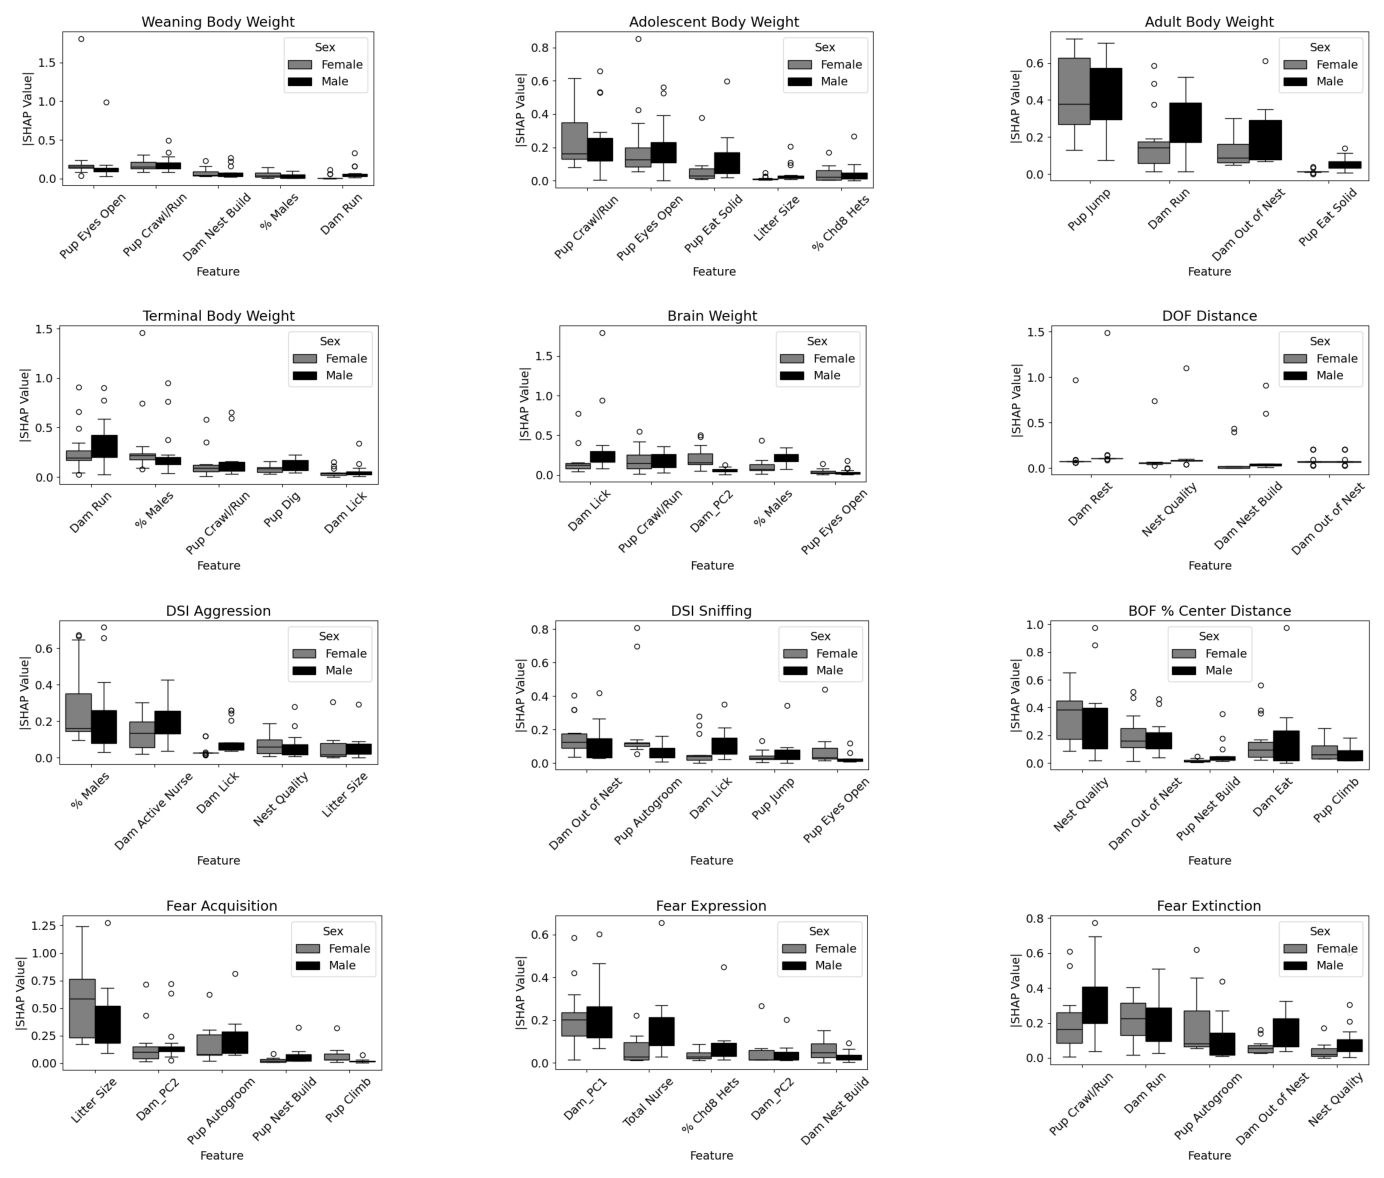

In [12]:
################## COMBINE PLOTS ##################
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
images = [['Weaning Body Weight', 'Adolescent Body Weight',
           'Adult Body Weight'], ['Terminal Body Weight', 'Brain Weight',
                                 'DOF Distance'], ['DSI Aggression', 'DSI Sniffing',
                                                    'BOF % Center Distance'], ['Fear Acquisition', 'Fear Expression',
                                                                                'Fear Extinction']]

# Loop over the rows and columns to display images
for row in [0, 1, 2, 3]:

    for column in [0, 1, 2]:
        ax = axes[row, column]
        ax.axis('off')
        image_name = images[row][column]
        img = mpimg.imread(f'Images/boxplot_{image_name}.png')
        ax.imshow(img)

# Adjust layout to make room for the figure title
plt.tight_layout()
# Save the figure with higher resolution
plt.savefig('Images/boxplot_shap.png', dpi=300, bbox_inches='tight')
plt.rc('font', size=14)

# Display the plot
plt.show()